In [10]:
from matplotlib import cm
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.ticker import LinearLocator, FormatStrFormatter

def plotSol(u, n):
    u = np.reshape(u, (n, n))
    
    X = np.arange(0, 1, 1 / n)
    Y = np.arange(0, 1, 1 / n)
    X, Y = np.meshgrid(X, Y)

    fig = plt.figure()
    ax = fig.gca(projection='3d')
    
    surf = ax.plot_surface(X, Y, u, cmap=cm.coolwarm)
    plt.show()

iter 0
iter 1
iter 2
iter 3
iter 4
iter 5
iter 6
iter 7
iter 8
iter 9
iter 10
iter 11
iter 12
iter 13
iter 14
iter 15
iter 16
iter 17
iter 18
iter 19
iter 20
iter 21
iter 22
iter 23
iter 24
iter 25
iter 26
iter 27
iter 28
iter 29
iter 30
iter 31
iter 32
iter 33
iter 34
iter 35
iter 36
iter 37
iter 38
iter 39
iter 40
iter 41
iter 42
iter 43
iter 44
iter 45
iter 46
iter 47
iter 48
iter 49


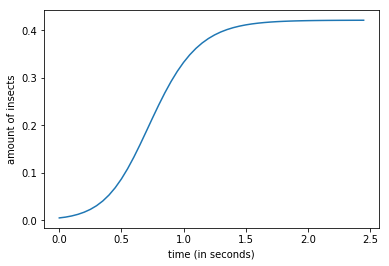

In [3]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
xc = [0.5, 0.5]

# Determine the value of g at point x=(x, y)
def g(x):
    if ((x[0]-xc[0])**2+(x[1]-xc[1])**2 < np.log(2)/10):
        return 0
    return 1 - 4*np.exp(-20*np.linalg.norm(np.subtract(x, xc))**2)

# Plot the values of g over the are (0, 1)^2
def plotg(dimension):
    temp = [[0 for x in range(dimension)] for y in range(dimension)] 
    for i in range(dimension):
        for j in range(dimension):
            temp[i][j] = g((i/dimension, j/dimension))
    plotSol(temp, dimension)

# Initialize the S matrix.
# S[y][x]
def init_S(n, kappa):
    S = np.zeros((n*n, n*n))
    h = 1/n
    for i in range(n*n):
        gn = g(((i%n)/n, (i//n+0.5)/n))
        ge = g(((i%n+0.5)/n, (i//n)/n))
        gs = g(((i%n)/n, (i//n-0.5)/n))
        gw = g(((i%n-0.5)/n, (i//n)/n))
        
        if (i < n):
            if (i == 0):
                S[i][i] = -(ge+gn)/2-h*kappa
                S[i][i+1] = ge/2
                S[i][i+n] = gn/2
            elif(i == n - 1):
                S[i][i] = -(gw+gn)/2-h*kappa
                S[i][i-1] = gw/2
                S[i][i+n] = gn/2
            else:
                S[i][i] = -gn-(ge+gw)/2-h*kappa
                S[i][i-1] = gw/2
                S[i][i+1] = ge/2
                S[i][i+n] = gn
                
        if (i >= n*(n-1)):
            if (i % n == 0):
                S[i][i] = -(ge+gs)/2-h*kappa
                S[i][i+1] = ge/2
                S[i][i-n] = gs/2
            elif ((i + 1) % n == 0):
                S[i][i] = -(gw+gs)/2-h*kappa
                S[i][i-1] = gw/2
                S[i][i-n] = gs/2
            else:
                S[i][i] = -gs-(ge+gw)/2-h*kappa
                S[i][i-1] = gw/2
                S[i][i+1] = ge/2
                S[i][i-n] = gs
                
        if (n <= i < n*(n-1)):
            if (i % n == 0):
                S[i][i] = -ge-(gs+gn)/2-h*kappa
                S[i][i+1] = ge
                
                S[i][i+n] = gn/2
                S[i][i-n] = gs/2
            elif ((i + 1) % n == 0):
                S[i][i] = -gw -(gs+gn)/2-h*kappa
                S[i][i-1] = gw
                
                S[i][i+n] = gn/2
                S[i][i-n] = gs/2
            else:
                S[i][i] = -gn-ge-gs-gw
                S[i][i-1] = gw
                S[i][i+1] = ge
                S[i][i-n] = gs
                S[i][i+n] = gn
    return S

# Initialize the M matrix
def init_M(dim):
    D = np.ones(dim)
    D[[0,-1]] = 0.5
    D = np.concatenate((0.5*D,np.tile(D,dim-2),0.5*D))
    M = np.diag(D)
    return (1/(dim*dim))*M

# Initialize the initial condition
def init_u0(n):
    u = np.zeros((n*n, 1))
    for i in range(0, n*n):
        ycord = (i // n) / n
        xcord = (i % n) / n
        x = (xcord, ycord)
        if (np.linalg.norm(x)**2 < 0.05):
            u[i] = 0.1
    return u

# Perform Backward Euler
def backwardEuler(M, S, lam, dt, u0, epsilon, dimension, maxiter):
    Minv = np.linalg.inv(M)
    MinvS = Minv @ S
    ukn = ukn1 = u0
    sol = np.zeros((maxiter, dimension*dimension))
    for n in range(maxiter):
        print("iter", n)
        norm = np.inf
        while(norm > epsilon):
            uk1n1 = np.linalg.solve((np.eye(dimension*dimension) - dt*MinvS), (ukn + dt*lam*(ukn1 * (np.ones(ukn1.shape)-ukn1))))
            norm = np.linalg.norm(ukn1 - uk1n1)
            ukn1 = uk1n1
        ukn = ukn1
        
        sol[n,:] = ukn[:,0]
    return sol

# Perform Forward Euler
def forwardEuler(M, S, lam, dt, u0, dimension, maxiter):
    Minv = np.linalg.inv(M)
    MinvS = Minv @ S
    
    un = un1 = u0
    sol = np.zeros((maxiter, dimension*dimension))
    for n in range(maxiter):
        un1 = un + dt*MinvS.dot(un) + dt*lam*(un*(1-un))
        un = un1
        sol[n,:] = un[:,0]
    return sol

# Integrate over the solution and return the total amount of insects
def total_amount(u, dimension):
    sum = 0
    h = 1 / dimension
    h2 = h*h
    for i in range(dimension):
        for j in range(dimension):
            sum+= h2*u[i*dimension + j]
    return sum

# Plot the total amount of insects over a given amount of time
# u should be the return value of either forwardEuler() or backwardEuler()
def plot_total_amount(u, dimension, iterations, timestep):
    u = np.empty((iterations, 1))
    for i in range(iterations):
        u[i, 0] = total_amount(res[i], dimension)
    x = np.arange(0, iterations*timestep, timestep)
    plt.plot(x, u)
    plt.xlabel("time")
    plt.ylabel("amount of insects")

# Set the values needed for computation
dimension = 25
iterations = 50
kappa = 1
lam = 10
step_size = 0.05
epsilon = 1e-6

# Backward Euler can be called as follows:
res = backwardEuler(init_M(dimension), init_S(dimension, kappa), lam, step_size, init_u0(dimension), epsilon, dimension, iterations)

# Forward Euler can be called as follows (a step_size smaller than 0.0005 is recommended):
# res = forwardEuler(init_M(dimension), init_S(dimension, kappa), lam, step_size, init_u0(dimension), dimension, iterations)

# The total amount of insects over time can be plotted as follows:
plot_total_amount(res, dimension, iterations, step_size)

#plotSol(res[36], dimension)

<Figure size 432x288 with 0 Axes>